In [32]:
%load_ext autoreload
%autoreload 2
import numpy as np
# np.seterr(divide='ignore') # these warnings are usually harmless for this code
# np.random.seed(0)
from matplotlib import pyplot as plt
import matplotlib
import os
matplotlib.rcParams['font.size'] = 14
plt.rcParams.update({'figure.figsize':[18,6]})

import sys
import pyhsmm
import pyhsmm.basic.distributions as distributions

sys.path.append('/home/kirilman/Projects/nir/main nir')
import myutils
import sequence_generator as generator
from HMMClassifier import SignalManager
import pomegranate as pg
from pyhsmm.util.text import progprint_xrange
from pyhsmm.util.general import rle
from myutils import plot_signal_label

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


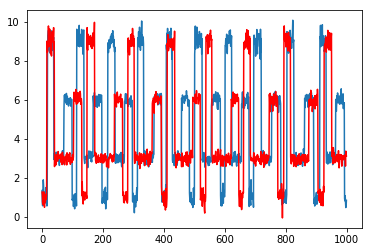

In [2]:
signal_manager = SignalManager()
signal_manager.read_paramets('config_hsmm.json')
signal = np.array(signal_manager.generators[0].sequence).reshape(-1,1)

test_signal = np.array(signal_manager.generators[1].sequence).reshape(-1,1)
plt.plot(signal[:,0])
plt.plot(test_signal[:,0],'r')

In [3]:
t = np.array(signal_manager.generators[1].sequence).reshape(-1,1)

In [40]:
#fit model
def create_model(data):
    obs_dim = 1
    dur_distns = []
    Nmax = 4
#     L = 5
#     obs_hypparams = {'alpha_0':np.zeros(L)+0.1,
#                     'K':L,
#                      'alphav_0':np.zeros(L)+0.1, 
#                      'alpha_mf':np.zeros(L)+0.1,
#                     }

    obs_hypparams = {'mu_0':np.zeros(obs_dim),
                    'sigma_0':np.eye(obs_dim),
                    'kappa_0':2,
                    'nu_0':obs_dim+5}
    obs_distns = [distributions.Gaussian(**obs_hypparams) for state in range(Nmax)]

    
    dur_hypparams = {'alpha_0':20,
                     'beta_0':1}
    dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]
    dur_hypparams = {'alpha_0':20,
                     'beta_0':1}
    dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]
    dur_hypparams = {'alpha_0':30,
                     'beta_0':1}
    dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]
    dur_hypparams = {'alpha_0':25,
                     'beta_0':1}
    dur_distns +=[distributions.PoissonDuration(**dur_hypparams)]
    
#     dur_distns = [distributions.PoissonDuration(**dur_hypparams) for state in range(Nmax)]

    posteriormodel = pyhsmm.models.WeakLimitHDPHSMM(
            alpha=6.,gamma=2., # better to sample over these; see concentration-resampling.py
            init_state_concentration=6., # pretty inconsequential
            obs_distns=obs_distns,
            dur_distns=dur_distns)
    posteriormodel.add_data(data) # duration truncation speeds things up when it's possible
    
    fig = plt.figure(figsize=(12,10),dpi = 140)
    for idx in progprint_xrange(150):
        posteriormodel.resample_model()
    plt.show()
    return posteriormodel

In [41]:
hsmm = create_model(signal);
# hsmm.resample_model()

Конструктор
.

/home/kirilman/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))


........................  [  25/150,    0.12sec avg, ETA 14.94 ]
.........................  [  50/150,    0.12sec avg, ETA 11.85 ]
.........................  [  75/150,    0.12sec avg, ETA 8.88 ]
.........................  [ 100/150,    0.12sec avg, ETA 5.92 ]
.........................  [ 125/150,    0.12sec avg, ETA 2.96 ]
.........................  [ 150/150,    0.12sec avg, ETA 0.00 ]

   0.12sec avg, 17.76 total



<Figure size 1680x1400 with 0 Axes>

/home/kirilman/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))


[0, 2, 3, 1]

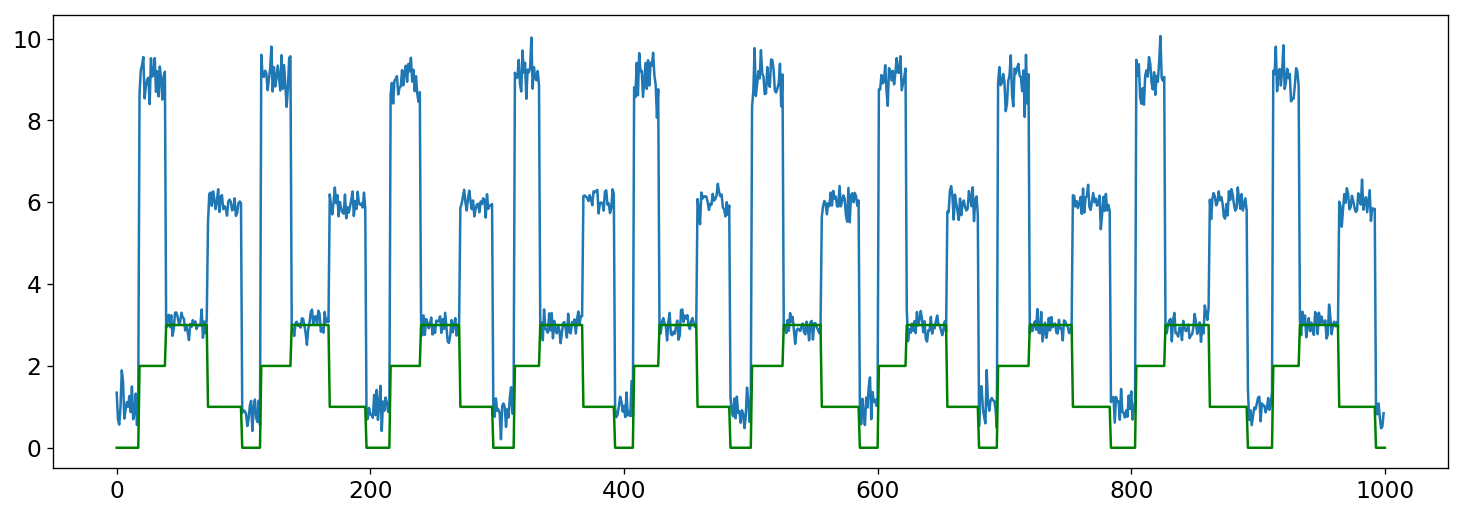

In [42]:
y_pred = hsmm.predict(signal,1)[1]
plot_signal_label(signal, y_pred);
hsmm.used_states

/home/kirilman/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))


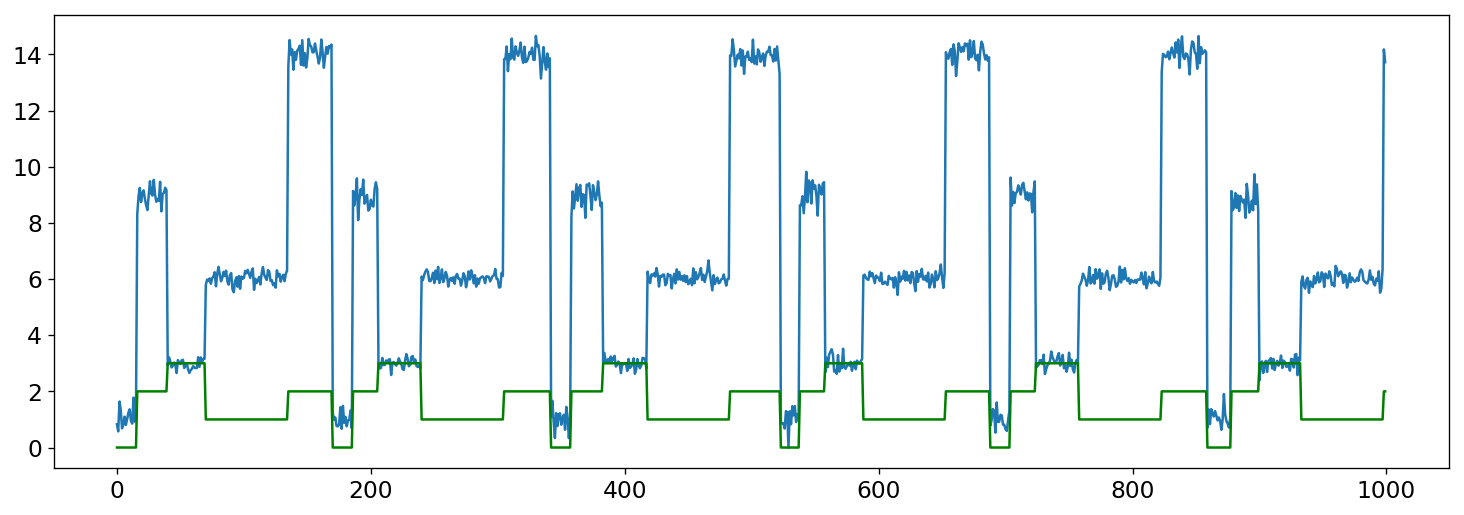

In [43]:
label = hsmm.predict(test_signal,0)[1];
plot_signal_label(test_signal, label);

In [44]:
print('ll train: {} , test: {}'.format(hsmm.log_likelihood(signal), hsmm.log_likelihood(test_signal)))

/home/kirilman/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))


ll train: -449.89828908855264 , test: -3436.9987130348304


/home/kirilman/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: divide by zero encountered in log
  return log(self._sf(x, *args))


-3436.9987130348304

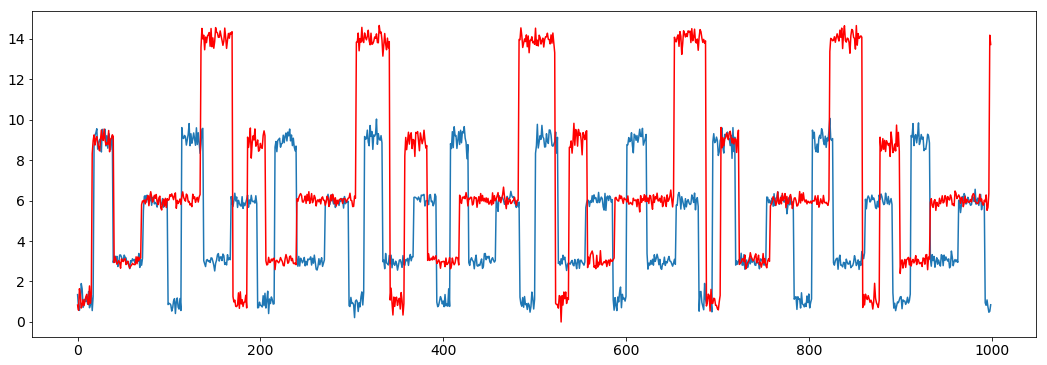

In [45]:
test_signal = np.array(signal_manager.generators[2].sequence).reshape(-1,1)

plt.plot(signal[:,0])
plt.plot(test_signal[:,0],'r')
hsmm.log_likelihood(test_signal)

In [46]:
for d in hsmm.dur_distns:
    print(d.params)
    print(d.hypparams)
    print(d.natural_hypparam)
    print(type(d))

{'lmbda': 17.49816885732601}
{'alpha_0': 20, 'beta_0': 1}
[ 1 19]
<class 'pyhsmm.basic.distributions.PoissonDuration'>
{'lmbda': 26.922530863261354}
{'alpha_0': 20, 'beta_0': 1}
[ 1 19]
<class 'pyhsmm.basic.distributions.PoissonDuration'>
{'lmbda': 21.406084059983954}
{'alpha_0': 30, 'beta_0': 1}
[ 1 29]
<class 'pyhsmm.basic.distributions.PoissonDuration'>
{'lmbda': 28.353239770915202}
{'alpha_0': 25, 'beta_0': 1}
[ 1 24]
<class 'pyhsmm.basic.distributions.PoissonDuration'>


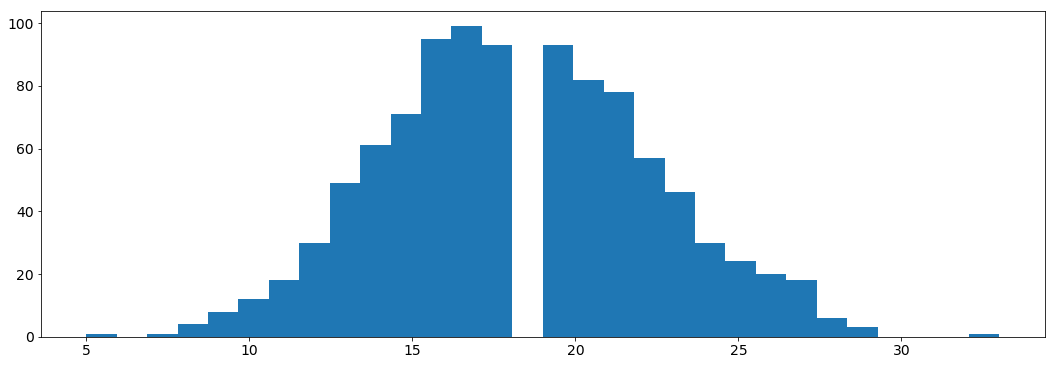

In [47]:
t = hsmm.dur_distns[0].rvs(1000)
plt.hist(t,np.array(30));

In [48]:
# hsmm.plot_durations()

In [49]:
len(hsmm.stateseqs_norep[0])

41

In [50]:
len(hsmm.stateseqs[0])

1000

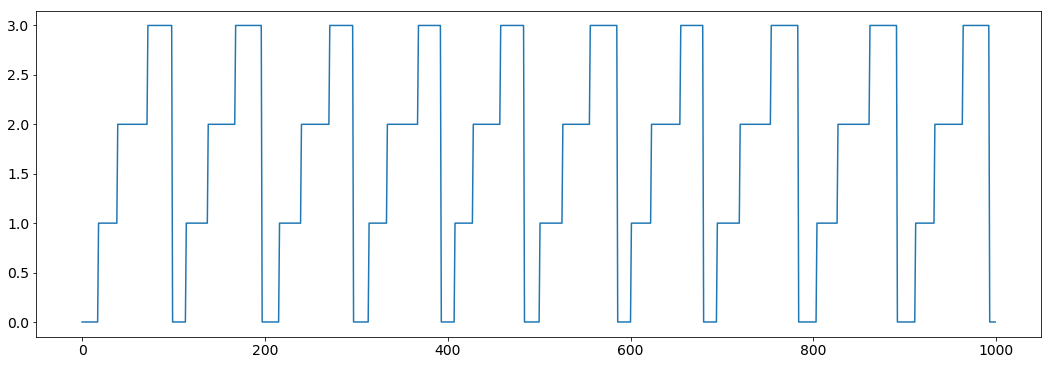

In [51]:
label = np.array(signal_manager.generators[0].path)
plt.plot(label)

In [52]:
from scipy.stats import poisson
hsmm.dur_distns[0].params['lmbda']

17.49816885732601

[2 3 1 0 2 3 1 0 2 3 1 0 2 3 1 0 2 3 0 3 1 0 2 3 1 0 2 3 1 3 0 2 3 1 0 2 3
 1 3 1 0 2 3 1 3 1 0 2 3 0 3 1 0 2 1 0 3 1 0 2 3 1 2 3 0 2 3 1 0 2 3 0 2 3
 0 2 3 1 0 2 3 1 0 2 3 2 3 0 2 3 1 0 2 3 0 2 3 0 2 3 1 0 2 0 3 0 2 3 0 2 3
 1 0 2 3 1 0 2 3 0 2 3 1 0 2 3 0 2 3 1 0 2 3 1 0 3 1 0 2 3 1 0 2 3 1 0 2 3
 1 0 2 3 1 0 2 3 0 3 0 2 3 1 0 2 3 0 2 3 1 0 2 3 1 0 2 0 2 3 1 0 2 3 1 0 2
 3 1 0 2 3 1 0 2 3 1 0 2 3 1 0 2 3 1] 
 [24 31 27 21 19 30 27 17 16 40 32 18 22 29 23 20 24 24 23 29 23 20 27 32
 31 15 15 31 30 28 20 15 33 37 24 21 31 24 28 25 22 26 27 34 46 26 25 27
 31 21 28 32 34 26 26 22 39 34 11 26 29 28 27 29 18 15 24 35 30 22 26 19
 26 26 22 18 27 32 18 19 32 25 14 18 28 25 30 15 25 28 27 14 20 37 18 20
 37 16 29 35 28 20 15 16 28 13 25 22 12 25 33 21 12 26 26 29 21 27 25 27
 20 29 24 21 15 31 18 24 15 29  9 22 35 29 21 28 30 11 18 34 28 19 27 29
 26 22 14 32 23 17 18 30 23 13 24 28 22 28 21 21 35 27 20 26 24 26 21 27
 29 18 25 36 27 19 12 26 22 25 26 23 20 36 22 23 29 26 35 21 23 34 44 22
 

TypeError: ufunc 'subtract' did not contain a loop with signature matching types dtype('<U21') dtype('<U21') dtype('<U21')

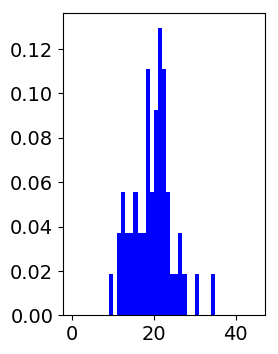

In [62]:
a, label = hsmm.generate(5000)
K = hsmm.num_states   # Количество состояний
fig = plt.figure(figsize=(3 * K, 4),dpi=100)
states, durations = rle(label)
print(states,'\n',durations)
max_duration = np.max(durations)
x_d = np.arange(max_duration,step = 1)

for i in range(K):
    
    print(i)
    plt.subplot(1, K, i+1)
    print(durations[states == i])
    plt.hist(durations[states == i], x_d, density=True,color = 'b')
#     plt.plot(np.random.laplace())
    if isinstance(hsmm.dur_distns[i],pyhsmm.basic.distributions.PoissonDuration):
        plt.plot(x_d, poisson.pmf(x_d,hsmm.dur_distns[0].params['lmbda'],'r))
    plt.title('State {}, (N = {})'.format(i,np.sum(durations[states == i])))
plt.show()

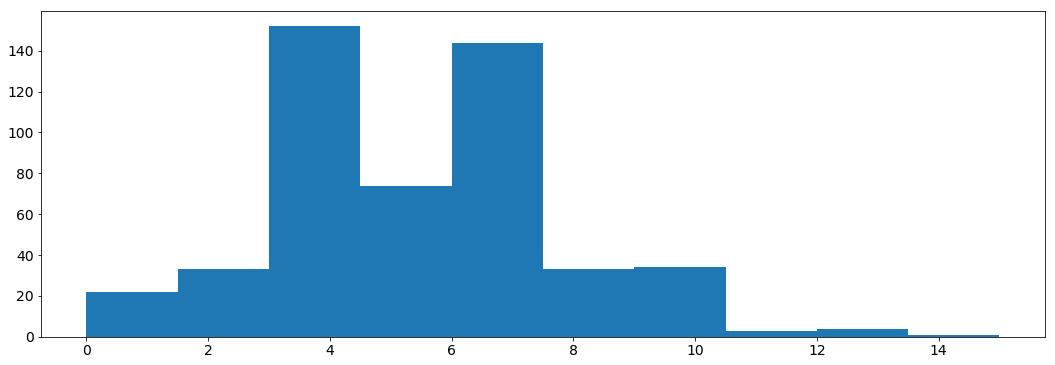

In [57]:
t = poisson.rvs(5,size = 500)
plt.hist(t);

In [19]:
np.sum(label == 1)

225

In [20]:
durations[states == i] 

array([27, 29, 26, 25, 26, 30, 25, 30, 30, 29])

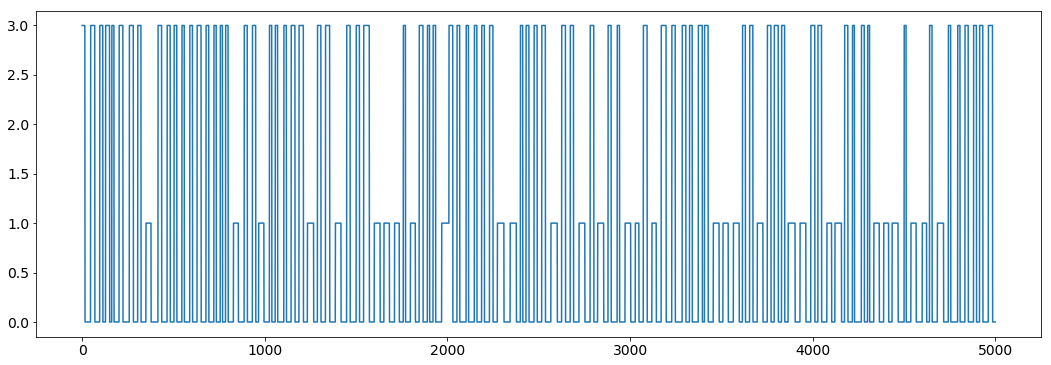

In [35]:
a,b = hsmm.generate(5000)
# plt.plot(a)
plt.plot(b)